In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras as k
from keras import layers
from sklearn.model_selection import train_test_split
import cv2
import os

os.environ["CUDA_VISIBLE_DEVICES"]="2"

2023-09-23 13:44:28.183102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 13:44:29.229791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/user/.conda/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# ============================== gpu info ==============================
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print("GPUs: ", tf.config.list_physical_devices("GPU"))

Num GPUs Available:  1
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-23 13:44:31.362685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 13:44:31.408439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 13:44:31.409512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# ============================== variables ==============================
image_size = 256
num_classes = 3

in_channel_tool = 3
in_channel_chip = 3
img_rows, img_cols = image_size, image_size
input_shape_tool = (img_rows, img_cols, in_channel_tool)
input_shape_chip = (img_rows, img_cols, in_channel_chip)

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
epochs = 100

In [4]:
# ============================== paths ==============================
# needed for generate_data
modality = "multi_tc"
exp_name = f"siren_reg"
sub_exp_name = f"base"
model_name = f"{exp_name}_{sub_exp_name}_{modality}"
model_save_path = f"{model_name}.h5"

model_tool_path = f"./{exp_name}_{sub_exp_name}_tool.h5"
model_chip_path = f"./{exp_name}_{sub_exp_name}_chip.h5"

# dataset
csv_path = "../../dataset/labels_reg_sample.csv"
tool_path = "../../dataset/tool"
chip_path = "../../dataset/chip"

In [5]:
# ============================== load/prepare dataset ==============================
df = pd.read_csv(csv_path)

# RANDOM DATASET: we switch to toolbased
# shuffle, need same state for tool/spec/chip/multi
np.random.seed(55)
df = df.iloc[np.random.permutation(len(df))]
# train/test/val : 70/15/15
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, val_df = train_test_split(test_df, test_size=0.5)

print(
    "size check train/test/val",
    len(train_df),
    len(test_df),
    len(val_df),
    (len(train_df) + len(test_df) + len(val_df)),
)

train_df["tool"] = train_df.id.map(lambda id: f"{tool_path}/{id}.jpg")
test_df["tool"] = test_df.id.map(lambda id: f"{tool_path}/{id}.jpg")
val_df["tool"] = val_df.id.map(lambda id: f"{tool_path}/{id}.jpg")

train_df["chip"] = train_df.id.map(lambda id: f"{chip_path}/{id}.jpg")
test_df["chip"] = test_df.id.map(lambda id: f"{chip_path}/{id}.jpg")
val_df["chip"] = val_df.id.map(lambda id: f"{chip_path}/{id}.jpg")

size check train/test/val 14 3 3 20


/home/user/.conda/envs/tf/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

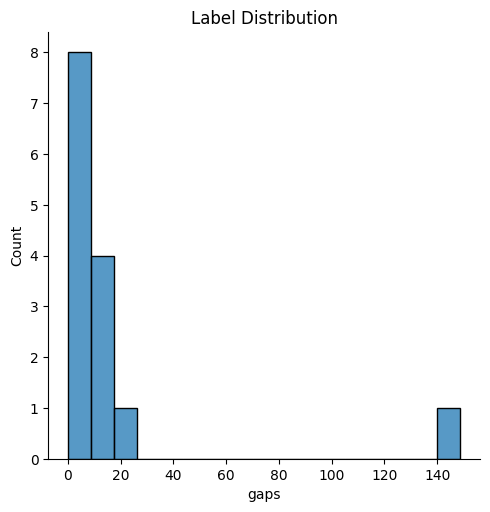

In [6]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["gaps"])
plt.title("Label Distribution")
plt.show()

/home/user/.conda/envs/tf/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

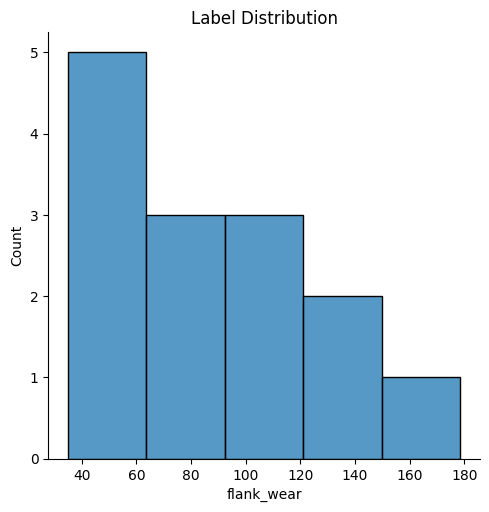

In [7]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["flank_wear"])
plt.title("Label Distribution")
plt.show()

/home/user/.conda/envs/tf/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x600 with 0 Axes>

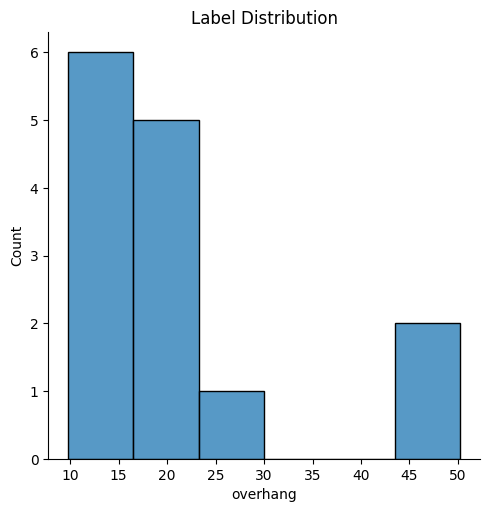

In [8]:
plt.figure(figsize=(6, 6))
sns.displot(train_df["overhang"])
plt.title("Label Distribution")
plt.show()

In [9]:
print("check if permutation is same on all models")
print("train_head", train_df.head())
print("test_head", test_df.head())
print("val_head", val_df.head())

check if permutation is same on all models
train_head          id   gaps  flank_wear  overhang                            tool  \
14   T8R3B4   6.88       40.92     14.54   ../../dataset/tool/T8R3B4.jpg   
10   T6R9B3  12.94       95.63     16.65   ../../dataset/tool/T6R9B3.jpg   
0    T1R2B1   7.67       34.89     48.61   ../../dataset/tool/T1R2B1.jpg   
3   T2R13B4   0.00      122.59     25.55  ../../dataset/tool/T2R13B4.jpg   
1    T1R7B4  13.89       85.41     50.25   ../../dataset/tool/T1R7B4.jpg   

                              chip  
14   ../../dataset/chip/T8R3B4.jpg  
10   ../../dataset/chip/T6R9B3.jpg  
0    ../../dataset/chip/T1R2B1.jpg  
3   ../../dataset/chip/T2R13B4.jpg  
1    ../../dataset/chip/T1R7B4.jpg  
test_head          id   gaps  flank_wear  overhang                            tool  \
16   T9R7B4   0.00       94.62     17.05   ../../dataset/tool/T9R7B4.jpg   
18  T10R3B4   0.00       44.26      7.10  ../../dataset/tool/T10R3B4.jpg   
9   T5R12B1  21.79      334.3

In [10]:
def read_tools(file_paths, img_rows, img_cols, channels):
    """
    Reads the spectogram files from disk and normalizes the pixel values
      @params:
        file_paths - Array of file paths to read from
        img_rows - The image height.
        img_cols - The image width.
        as_grey - Read the image as Greyscale or RGB.
        channels - Number of channels.
      @returns:
        The created and compiled model (Model)
    """
    images = []

    for file_path in file_paths:
        img = cv2.imread(file_path)
        res = cv2.resize(img, dsize=(img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        images.append(res)

    images = np.asarray(images, dtype=np.float32)

    # normalize
    images = images / np.max(images)

    # reshape to match Keras expectaions
    images = images.reshape(images.shape[0], img_rows, img_cols, channels)

    return images

In [11]:
x_train_tool = read_tools(train_df.tool.values, img_rows, img_cols, in_channel_tool)
x_test_tool = read_tools(test_df.tool.values, img_rows, img_cols, in_channel_tool)
x_val_tool = read_tools(val_df.tool.values, img_rows, img_cols, in_channel_tool)

x_train_chip = read_tools(train_df.chip.values, img_rows, img_cols, in_channel_chip)
x_test_chip = read_tools(test_df.chip.values, img_rows, img_cols, in_channel_chip)
x_val_chip = read_tools(val_df.chip.values, img_rows, img_cols, in_channel_chip)

In [12]:
x_train_tool.shape

(14, 256, 256, 3)

In [13]:
x_train_chip.shape

(14, 256, 256, 3)

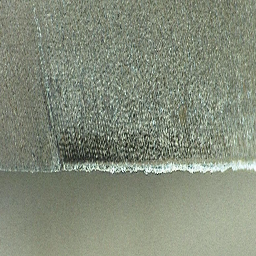

In [14]:
pil_img = tf.keras.utils.array_to_img(x_train_tool[0])
pil_img

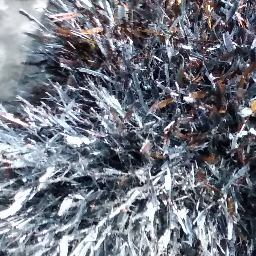

In [15]:
pil_img = tf.keras.utils.array_to_img(x_train_chip[0])
pil_img

In [16]:
labels_train = train_df[["gaps", "flank_wear", "overhang"]]
labels_test = test_df[["gaps", "flank_wear", "overhang"]]
labels_val = val_df[["gaps", "flank_wear", "overhang"]]

In [17]:
# ============================== augment 1/2 ==============================
data_augmentation_tool = k.Sequential(
    [
        k.layers.RandomBrightness(factor=(-0.2,0.2), value_range=(0, 1)),
        k.layers.RandomContrast(factor=0.2),
        k.layers.GaussianNoise(stddev=0.2),
    ],
    name="data_augmentation_tool",
)

2023-09-23 13:44:34.635188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 13:44:34.636153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 13:44:34.637028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [18]:
# ============================== augment 2/2 ==============================
data_augmentation_chip = k.Sequential(
    [
        k.layers.RandomBrightness(factor=(-0.2,0.2), value_range=(0, 1)),
        k.layers.RandomContrast(factor=0.2),
        k.layers.GaussianNoise(stddev=0.2),
    ],
    name="data_augmentation_chip",
)

In [19]:
x_train_tool = data_augmentation_tool(x_train_tool)
x_train_chip = data_augmentation_chip(x_train_chip)

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_tool": x_train_tool,
            "input_1_chip": x_train_chip,
        },
        labels_train,
    )
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_tool": x_test_tool,
            "input_1_chip": x_test_chip,
        },
        labels_test,
    )
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "input_1_tool": x_val_tool,
            "input_1_chip": x_val_chip,
        },
        labels_val,
    )
)

In [21]:
auto = tf.data.AUTOTUNE
inputs1 = k.Input(input_shape_tool)
inputs3 = k.Input(input_shape_chip)

In [22]:
def generate_datasets(images, is_train=False, shuffle=False):
    dataset = images
    if shuffle:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        pass
    return dataset.prefetch(auto)

In [23]:
train_ds = generate_datasets(train_dataset, is_train=True, shuffle=True)
val_ds = generate_datasets(val_dataset)
test_ds = generate_datasets(test_dataset)

In [24]:
train_ds

<_PrefetchDataset element_spec=({'input_1_tool': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), 'input_1_chip': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [25]:
model_tool = k.models.load_model(model_tool_path, compile=False)
model_chip = k.models.load_model(model_chip_path, compile=False)

model_tool.trainable = False
model_chip.trainable = False


def load_siren(model_tool, model_chip):
    inputs1 = model_tool.input
    inputs1._name = "input_tool"
    inputs3 = model_chip.input
    inputs3._name = "input_chip"

    truncated_model_tool = k.Model(
        inputs=model_tool.input, outputs=model_tool.layers[-2].output
    )
    truncated_model_chip = k.Model(
        inputs=model_chip.input, outputs=model_chip.layers[-2].output
    )
    mergedOut = k.layers.Concatenate()(
        [
            truncated_model_tool.output,
            truncated_model_chip.output,
        ]
    )
    output = layers.Dense(num_classes, activation="linear", name="output_mult")(
        mergedOut
    )
    return k.Model(inputs=[inputs1, inputs3], outputs=output)


for layer in model_tool.layers:
    layer._name = layer.name + str("_tool")
for layer in model_chip.layers:
    layer._name = layer.name + str("_chip")

In [26]:
def launch_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer, loss="mse", metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
    )

    _, accuracy = model.evaluate(test_ds)
    print(f"Test error: {round(accuracy, 2)}")

    return history, model

In [27]:
model = load_siren(model_tool, model_chip)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_tool (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_1_chip (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_tool (Conv2D)           (None, 16, 16, 256)  196864      ['input_1_tool[0][0]']           
                                                                                            

In [28]:
history, model = launch_experiment(model)

Epoch 1/100


2023-09-23 13:44:40.006296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [14,256,256,3]
	 [[{{node Placeholder/_1}}]]
2023-09-23 13:44:40.006956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [14,256,256,3]
	 [[{{node Placeholder/_0}}]]
2023-09-23 13:44:49.190927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


2/2 [==============================] - ETA: 0s - loss: 3794.8438 - mean_squared_error: 3794.8438

2023-09-23 13:44:50.097204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,3]
	 [[{{node Placeholder/_2}}]]


2/2 [==============================] - 12s 2s/step - loss: 3794.8438 - mean_squared_error: 3794.8438 - val_loss: 4602.7720 - val_mean_squared_error: 4602.7720
Epoch 2/100
2/2 [==============================] - 0s 55ms/step - loss: 3689.7715 - mean_squared_error: 3689.7712 - val_loss: 4477.3320 - val_mean_squared_error: 4477.3320
Epoch 3/100
2/2 [==============================] - 0s 53ms/step - loss: 3592.5703 - mean_squared_error: 3592.5703 - val_loss: 4355.6416 - val_mean_squared_error: 4355.6416
Epoch 4/100
2/2 [==============================] - 0s 47ms/step - loss: 3505.8298 - mean_squared_error: 3505.8298 - val_loss: 4237.4507 - val_mean_squared_error: 4237.4507
Epoch 5/100
2/2 [==============================] - 0s 46ms/step - loss: 3408.2317 - mean_squared_error: 3408.2317 - val_loss: 4123.6836 - val_mean_squared_error: 4123.6836
Epoch 6/100
2/2 [==============================] - 0s 49ms/step - loss: 3326.1519 - mean_squared_error: 3326.1519 - val_loss: 4013.5940 - val_mean_square

2023-09-23 13:44:59.805490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,3]
	 [[{{node Placeholder/_2}}]]


In [29]:
model.save(model_save_path)

In [30]:
pred = model.predict(test_ds)

1/1 [==============================] - 2s 2s/step


In [31]:
# ============================== generate data ==============================
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import PredictionErrorDisplay
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras as k

In [32]:
multi_pred = pred
gaps_pred, flank_wear_pred, overhang_pred = multi_pred.T

multi_true = labels_test.to_numpy()
gaps_true, flank_wear_true, overhang_true = multi_true.T

In [33]:
labels_list = [
    "gaps",
    "flank_wear",
    "overhang",
    "multi",
]
pred_list = [
    gaps_pred,
    flank_wear_pred,
    overhang_pred,
    multi_pred,
]
true_list = [
    gaps_true,
    flank_wear_true,
    overhang_true,
    multi_true,
]

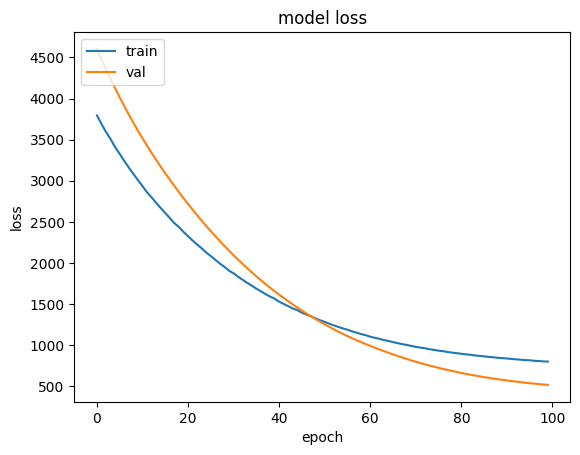

In [34]:
# loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

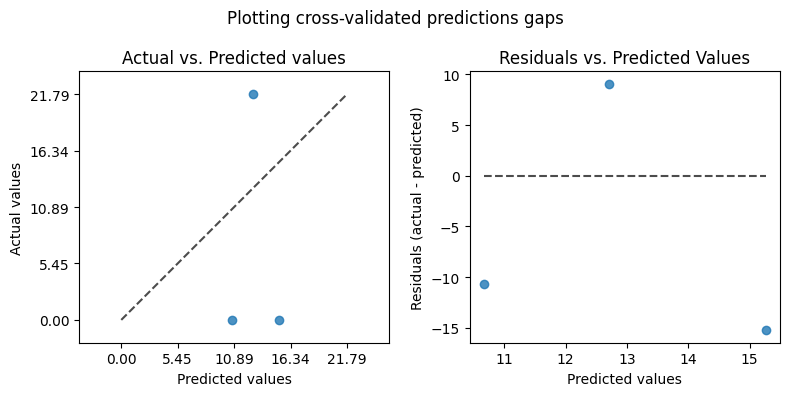

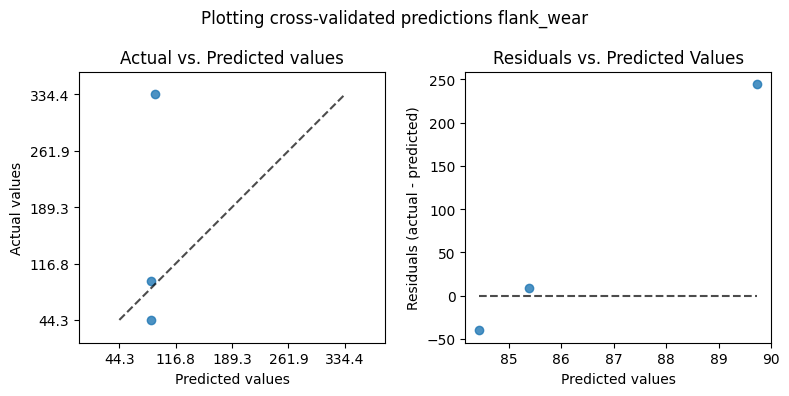

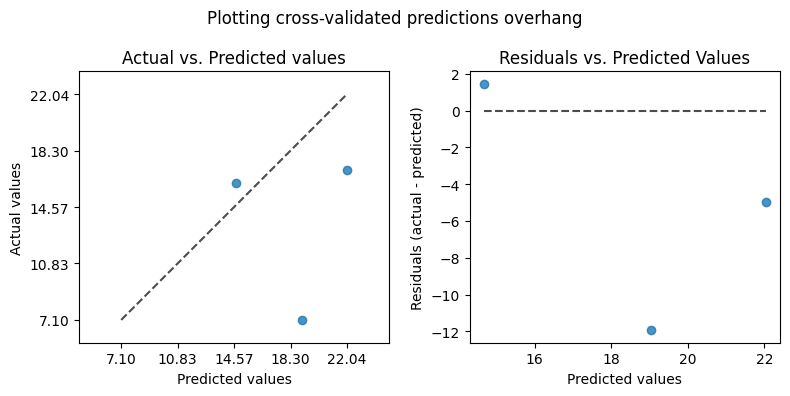

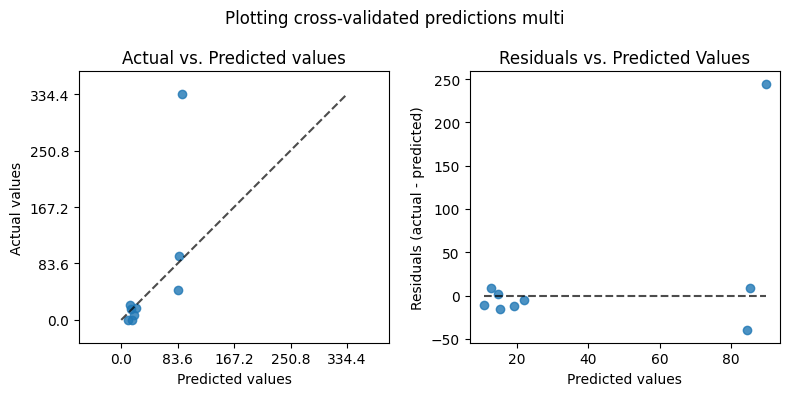

In [35]:
for label, y_pred, y_true in zip(labels_list, pred_list, true_list):
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions " + label)
    plt.tight_layout()
    plt.show()

In [36]:
def min_shift(list1, list2):
    list1 = np.array(list1)
    list2 = np.array(list2)
    if list1.ndim == 2:
        for i in range(len(list1)):
            if np.min([list1, list2]) > 0:
                continue
            min = np.min([list1[i], list2[i]])
            list1[i] -= min
            list2[i] -= min
        return list1, list2

    min = np.min([list1, list2])
    list1 = list1 - min
    list2 = list1 - min

    return list1, list2

In [37]:
for label, y_pred, y_true in zip(labels_list, pred_list, true_list):
    print(f"===== {label} results =====")
    print("MAE: ", metrics.mean_absolute_error(y_true, y_pred))
    print("MSE: ", metrics.mean_squared_error(y_true, y_pred))
    print("RMSE: ", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r2_score: ", metrics.r2_score(y_true, y_pred))
    try:
        print("MSLE: ", metrics.mean_squared_log_error(y_true, y_pred))
    except ValueError as err:
        y_true_shift, y_pred_shift = min_shift(y_true, y_pred)
        print(
            "MSLE_min_shifted: ",
            metrics.mean_squared_log_error(y_true_shift, y_pred_shift),
        )
    print("MAPE: ", metrics.mean_absolute_percentage_error(y_true, y_pred))

===== gaps results =====
MAE:  11.672055892944336
MSE:  143.10819455447154
RMSE:  11.962783729319508
r2_score:  -0.35632121857229526
MSLE:  4.690753410625644
MAPE:  3.892656850390221e+16
===== flank_wear results =====
MAE:  98.02207692464192
MSE:  20518.2245848153
RMSE:  143.24183950513657
r2_score:  -0.2805997594451195
MSLE:  0.7076950615008841
MAPE:  0.5789891432648928
===== overhang results =====
MAE:  6.135181821187338
MSE:  56.618647187847074
RMSE:  7.524536343712287
r2_score:  -1.8067289996520208
MSLE:  0.296371684943796
MAPE:  0.6888805898824922
===== multi results =====
MAE:  38.60977154625786
MSE:  6905.983808852539
RMSE:  54.24305319272279
r2_score:  -0.8145499925564786
MSLE:  1.898273385690108
MAPE:  1.297552283463407e+16
